In [1]:
import numpy as np
import pandas as pd
import os
import re
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

pd.options.display.max_colwidth = 100

p_data_raw       = os.path.abspath('../data/raw') # raw data path
p_data_processed = os.path.abspath('../data/processed') # processed data path
p_data_cleaned   = os.path.abspath('../data/cleaned') # clearned data path
p_data_src       = os.path.abspath('../data/src') # src data path

# MovieLens datasets
ml_links   = pd.read_csv(p_data_raw+'/ml-25m/links.csv') # movie links
ml_ratings = pd.read_csv(p_data_raw+'/ml-25m/ratings.csv') # user ratings
ml_movies  = pd.read_csv(p_data_raw+'/ml-25m/movies.csv') # movie list

# MovieLens tags
ml_tags          = pd.read_csv(p_data_raw+'/ml-25m/tags.csv') # userId, movieId, tag, timestamp
ml_genome_tags   = pd.read_csv(p_data_raw+'/ml-25m/genome-tags.csv') # tagId, tag
ml_genome_scores = pd.read_csv(p_data_raw+'/ml-25m/genome-scores.csv') # movieId, tagId, relevance

In [2]:
# IMDB Kmovie list
imdb_mat_orig = pd.read_pickle(p_data_raw+'/imdb_kr.pickle')

# IMDB Kmovie list join MovieLens
imdb_mat = pd.merge(imdb_mat_orig,ml_links,on='imdbId')

# IMDB Kmovie list join MovieLens movie list
imdb_mat = pd.merge(imdb_mat,ml_movies,on='movieId')

# MovieLens ratings join IMDB Kmovie list
# k_ratings = pd.merge(ml_ratings,imdb_mat,how='right',on='movieId')
k_ratings = pd.merge(ml_ratings,imdb_mat,on='movieId')

In [3]:
print('Total Korean movies scraped from IMDB: {}'.format(len(imdb_mat_orig)))
print('Total Korean movies found in MovieLens movies Dataset: {}'.format(len(imdb_mat)))

# create a user list
userId_list = k_ratings['userId'].unique().tolist()

# create a rating dataframe for all ratings
ratings = ml_ratings[ml_ratings.userId.isin(userId_list)]
ratings = pd.merge(ratings,ml_movies,on='movieId')

# Korean movie list
k_movie_list = k_ratings['movieId'].unique().tolist()

print('Total User #: {}'.format(len(userId_list)))

# ratings exclude kmovie
nk_ratings = ratings[~ratings.movieId.isin(k_movie_list)]

print('\n')
print('Total Ratings #: {}'.format(ratings.shape[0]))
print('Korean Movie Ratings #: {}'.format(k_ratings.shape[0]))
print('Non-Korean Movie Ratings #: {}'.format(nk_ratings.shape[0]))

# movie list
movie_list = ratings['movieId'].unique().tolist()
nk_movie_list = nk_ratings['movieId'].unique().tolist()

print('\n')
print('Total Movie #: {}'.format(len(movie_list)))
print('Korean Movie #: {}'.format(len(k_movie_list)))
print('Non-Korean Movie #: {}'.format(len(nk_movie_list)))

print('\n')
print('Note: 8 Korean Movie has no ratings in MovieLens rating dataset')

Total Korean movies scraped from IMDB: 10000
Total Korean movies found in MovieLens movies Dataset: 700
Total User #: 18567


Total Ratings #: 7912645
Korean Movie Ratings #: 46663
Non-Korean Movie Ratings #: 7865982


Total Movie #: 57507
Korean Movie #: 692
Non-Korean Movie #: 56815


Note: 8 Korean Movie has no ratings in MovieLens rating dataset


In [4]:
# Update imdb_mat
# 8 Korean Movie has no ratings in rating dataset
imdb_mat = imdb_mat[imdb_mat.movieId.isin(k_movie_list)]

In [5]:
# find 50% quantile of movie counts
k_ratings.groupby('movieId')['userId'].count().sort_values(ascending=False).to_frame().quantile(0.50)

userId    7.0
Name: 0.5, dtype: float64

In [6]:
# find kmovies with >= cutoff ratings
cutoff = 7
k_movie_list_t = k_ratings.groupby('movieId')['userId'].count().sort_values(ascending=False).to_frame()
k_movie_list_c = k_movie_list_t[k_movie_list_t['userId']>=cutoff].index.tolist()

print('Korean Movie # with >= {} ratings: {}'.format(cutoff, len(k_movie_list_c)))

imdb_mat_c = imdb_mat[imdb_mat.movieId.isin(k_movie_list_c)]
k_ratings_c = k_ratings[k_ratings.movieId.isin(k_movie_list_c)]

# user list cutted
userId_list_c = k_ratings_c['userId'].unique().tolist()

print('\n')
print('Cutted Total User #: {}'.format(len(userId_list_c)))

# create a rating dataframe for all ratings - cutted user list
ratings_c = ml_ratings[ml_ratings.userId.isin(userId_list_c)]
ratings_c = pd.merge(ratings_c,ml_movies,on='movieId')

# ratings exclude kmovie
nk_ratings_c = ratings_c[~ratings_c.movieId.isin(k_movie_list_c)]

print('\n')
print('Cutted Total Ratings #: {}'.format(ratings_c.shape[0]))
print('Cutted Korean Movie Ratings #: {}'.format(k_ratings_c.shape[0]))
print('Cutted Non-Korean Movie Ratings #: {}'.format(nk_ratings_c.shape[0]))

# cutted movie list
movie_list_c = ratings_c['movieId'].unique().tolist()
nk_movie_list_c = nk_ratings_c['movieId'].unique().tolist()

print('\n')
print('Cutted Total Movie #: {}'.format(len(movie_list_c)))
print('Cutted Korean Movie #: {}'.format(len(k_movie_list_c)))
print('Cutted Non-Korean Movie #: {}'.format(len(nk_movie_list_c)))

Korean Movie # with >= 7 ratings: 353


Cutted Total User #: 18543


Cutted Total Ratings #: 7908358
Cutted Korean Movie Ratings #: 45747
Cutted Non-Korean Movie Ratings #: 7862611


Cutted Total Movie #: 57479
Cutted Korean Movie #: 353
Cutted Non-Korean Movie #: 57126


In [7]:
# extract 1st genre
nk_ratings_c['genre1'] = nk_ratings_c['genres'].apply(lambda s:s.split('|')[0])
k_ratings_c['genre1'] = k_ratings_c['genres'].apply(lambda s:s.split('|')[0])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
print(nk_ratings_c.groupby('genre1')['movieId'].count().sort_values(ascending=False))
# print(nk_ratings_c.groupby('genre1')['movieId'].nunique().sort_values(ascending=False))

print(k_ratings_c.groupby('genre1')['movieId'].count().sort_values(ascending=False))
# print(k_ratings_c.groupby('genre1')['movieId'].nunique().sort_values(ascending=False))

genre1
Action                2361023
Comedy                1622857
Drama                 1577790
Adventure              716611
Crime                  593738
Horror                 274960
Animation              196438
Documentary            135062
Children               105192
Mystery                 71998
Thriller                52883
Sci-Fi                  46235
Fantasy                 38032
(no genres listed)      20467
Western                 18340
Romance                 13471
Film-Noir                9557
Musical                  6372
War                      1579
IMAX                        6
Name: movieId, dtype: int64
genre1
Mystery               12412
Action                11271
Drama                  9062
Crime                  7767
Comedy                 3763
Thriller                433
Horror                  380
Animation               356
Fantasy                  90
(no genres listed)       84
Sci-Fi                   33
War                      32
Adventure             

In [9]:
# remove missing genres for kmovie
nk_ratings_c['genre1'] = nk_ratings_c['genre1'].apply(lambda s:re.sub(
    'Fantasy|Adventure|Romance|Documentary|Children|Sci-Fi|War|Western|Musical|Film-Noir|IMAX',
    'Other',s).replace('(no genres listed)','Other'))
k_ratings_c['genre1'] = k_ratings_c['genre1'].apply(lambda s:re.sub(
    'Fantasy|Adventure|Romance|Documentary|Children|Sci-Fi|War|Western|Musical|Film-Noir|IMAX',
    'Other',s).replace('(no genres listed)','Other'))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [10]:
print(nk_ratings_c.groupby('genre1')['movieId'].count().sort_values(ascending=False))
print(k_ratings_c.groupby('genre1')['movieId'].count().sort_values(ascending=False))

# print(nk_ratings_c.groupby('genre1')['movieId'].nunique().sort_values(ascending=False))
# print(k_ratings_c.groupby('genre1')['movieId'].nunique().sort_values(ascending=False))

genre1
Action       2361023
Comedy       1622857
Drama        1577790
Other        1110924
Crime         593738
Horror        274960
Animation     196438
Mystery        71998
Thriller       52883
Name: movieId, dtype: int64
genre1
Mystery      12412
Action       11271
Drama         9062
Crime         7767
Comedy        3763
Thriller       433
Horror         380
Animation      356
Other          303
Name: movieId, dtype: int64


In [11]:
# get rid of "other" genres
nk_ratings_f = nk_ratings_c[nk_ratings_c['genre1']!='Other']
print(nk_ratings_f.groupby('genre1')['movieId'].count().sort_values(ascending=False))

k_ratings_f = k_ratings_c[k_ratings_c['genre1']!='Other']
print(k_ratings_f.groupby('genre1')['movieId'].count().sort_values(ascending=False))

genre1
Action       2361023
Comedy       1622857
Drama        1577790
Crime         593738
Horror        274960
Animation     196438
Mystery        71998
Thriller       52883
Name: movieId, dtype: int64
genre1
Mystery      12412
Action       11271
Drama         9062
Crime         7767
Comedy        3763
Thriller       433
Horror         380
Animation      356
Name: movieId, dtype: int64


In [12]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

userId_list_f = intersection(nk_ratings_f['userId'].tolist(),k_ratings_f['userId'].tolist())

# remove user not in k_ratings_f

print(len(nk_ratings_f.groupby('userId')['movieId'].count().sort_values(ascending=False)))
print(len(k_ratings_f.groupby('userId')['movieId'].count().sort_values(ascending=False)))
print(len(userId_list_f))

nk_ratings_f = nk_ratings_f[nk_ratings_f.userId.isin(userId_list_f)]

18543
18529
18529


In [13]:
# genre mat exclude kmovie
genremat_nk_mean = nk_ratings_f.pivot_table(index='userId',columns='genre1',values='rating')
genremat_nk_count = nk_ratings_f.pivot_table(index='userId',columns='genre1',values='rating',
                                             aggfunc=len,fill_value=0)

In [14]:
# remove genres contain nan
genremat_nk_mean_f = genremat_nk_mean.dropna()

userId_list_f = genremat_nk_mean_f.index.tolist()

genremat_nk_count_f = genremat_nk_count[genremat_nk_count.index.isin(userId_list_f)]

genremat_k_mean = k_ratings_f.pivot_table(index='userId',columns='genre1',values='rating_x')
genremat_k_count = k_ratings_f.pivot_table(index='userId',columns='genre1',values='rating_x',
                                             aggfunc=len,fill_value=0)
genremat_k_mean_f = genremat_k_mean[genremat_k_mean.index.isin(userId_list_f)]
genremat_k_count_f = genremat_k_count[genremat_k_count.index.isin(userId_list_f)]

In [15]:
# user list final
print('Final Total User #: {}'.format(len(userId_list_f)))

# create a rating dataframe for all ratings - final user list
ratings_f = ratings_c[ratings_c.userId.isin(userId_list_f)]
ratings_f = pd.merge(ratings_f,ml_movies,on='movieId')

k_ratings_f = k_ratings_c[k_ratings_c.userId.isin(userId_list_f)]
nk_ratings_f = nk_ratings_c[nk_ratings_c.userId.isin(userId_list_f)]

print('\n')
print('Final Total Ratings #: {}'.format(ratings_f.shape[0]))
print('Final Korean Movie Ratings #: {}'.format(k_ratings_f.shape[0]))
print('Final Non-Korean Movie Ratings #: {}'.format(nk_ratings_f.shape[0]))

# final movie list
movie_list_f = ratings_f['movieId'].unique().tolist()
k_movie_list_f = k_ratings_f['movieId'].unique().tolist()
nk_movie_list_f = nk_ratings_f['movieId'].unique().tolist()

print('\n')
print('Final Total Movie #: {}'.format(len(movie_list_f)))
print('Final Korean Movie #: {}'.format(len(k_movie_list_f)))
print('Final Non-Korean Movie #: {}'.format(len(nk_movie_list_f)))

Final Total User #: 9782


Final Total Ratings #: 6564712
Final Korean Movie Ratings #: 32278
Final Non-Korean Movie Ratings #: 6532434


Final Total Movie #: 57034
Final Korean Movie #: 353
Final Non-Korean Movie #: 56681


In [16]:
# smooth out the extreme rate from few ratings

genremat_mean = genremat_nk_mean_f.to_numpy()
genremat_count = genremat_nk_count_f.to_numpy()

# calculate weighted rating of each genre - (counts/(counts+cutoff) * means) + (cutoff/(counts+cutoff) * M)
genremat_combined=np.empty((len(userId_list_f), genremat_nk_mean_f.shape[1]))

# M = genremat_nk_mean.mean() # by genre/column
# for i in range(len(genremat_mean)):
#     for j in range(len(genremat_mean[i])):
#         genremat_combined[i][j] = (genremat_count[i][j]/(genremat_count[i][j]+cutoff)*genremat_mean[i][j]
#                                   )+(cutoff/(genremat_count[i][j]+cutoff)*M[j])
        
M = genremat_nk_mean.mean(axis=1) # by user/row
for i in range(len(genremat_mean)):
    for j in range(len(genremat_mean[i])):
#         genremat_combined[i][j] = (genremat_count[i][j]/(genremat_count[i][j]+cutoff)*genremat_mean[i][j]
#                                   )+(cutoff/(genremat_count[i][j]+cutoff)*M.iloc[i])
        genremat_combined[i][j] = (genremat_count[i][j]/(genremat_count[i][j]+genremat_count[i].min())*genremat_mean[i][j]
                                  )+(genremat_count[i].min()/(genremat_count[i][j]+genremat_count[i].min())*M.iloc[i])
    
genremat_nk_mean_f_adj = pd.DataFrame(
    genremat_combined,index=genremat_nk_mean_f.index, columns=genremat_nk_mean_f.columns)

genre1
Action       3.639640
Animation    4.227273
Comedy       3.342391
Crime        4.147727
Drama        3.962963
Horror       3.437500
Mystery      3.928571
Thriller     3.375000
Name: 3, dtype: float64
genre1
Action       3.641005
Animation    4.101253
Comedy       3.359571
Crime        4.114975
Drama        3.953162
Horror       3.543233
Mystery      3.865345
Thriller     3.564849
Name: 3, dtype: float64
genre1
Action       333
Animation     11
Comedy        92
Crime         44
Drama         81
Horror         8
Mystery        7
Thriller       4
Name: 3, dtype: int64


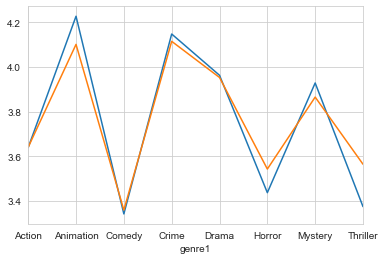

In [17]:
i = 0
# i = 6
# i = 100
# i = 2000
genremat_nk_mean_f.iloc[i].plot()
genremat_nk_mean_f_adj.iloc[i].plot()
print(genremat_nk_mean_f.iloc[i])
print(genremat_nk_mean_f_adj.iloc[i])
print(genremat_nk_count_f.iloc[i])

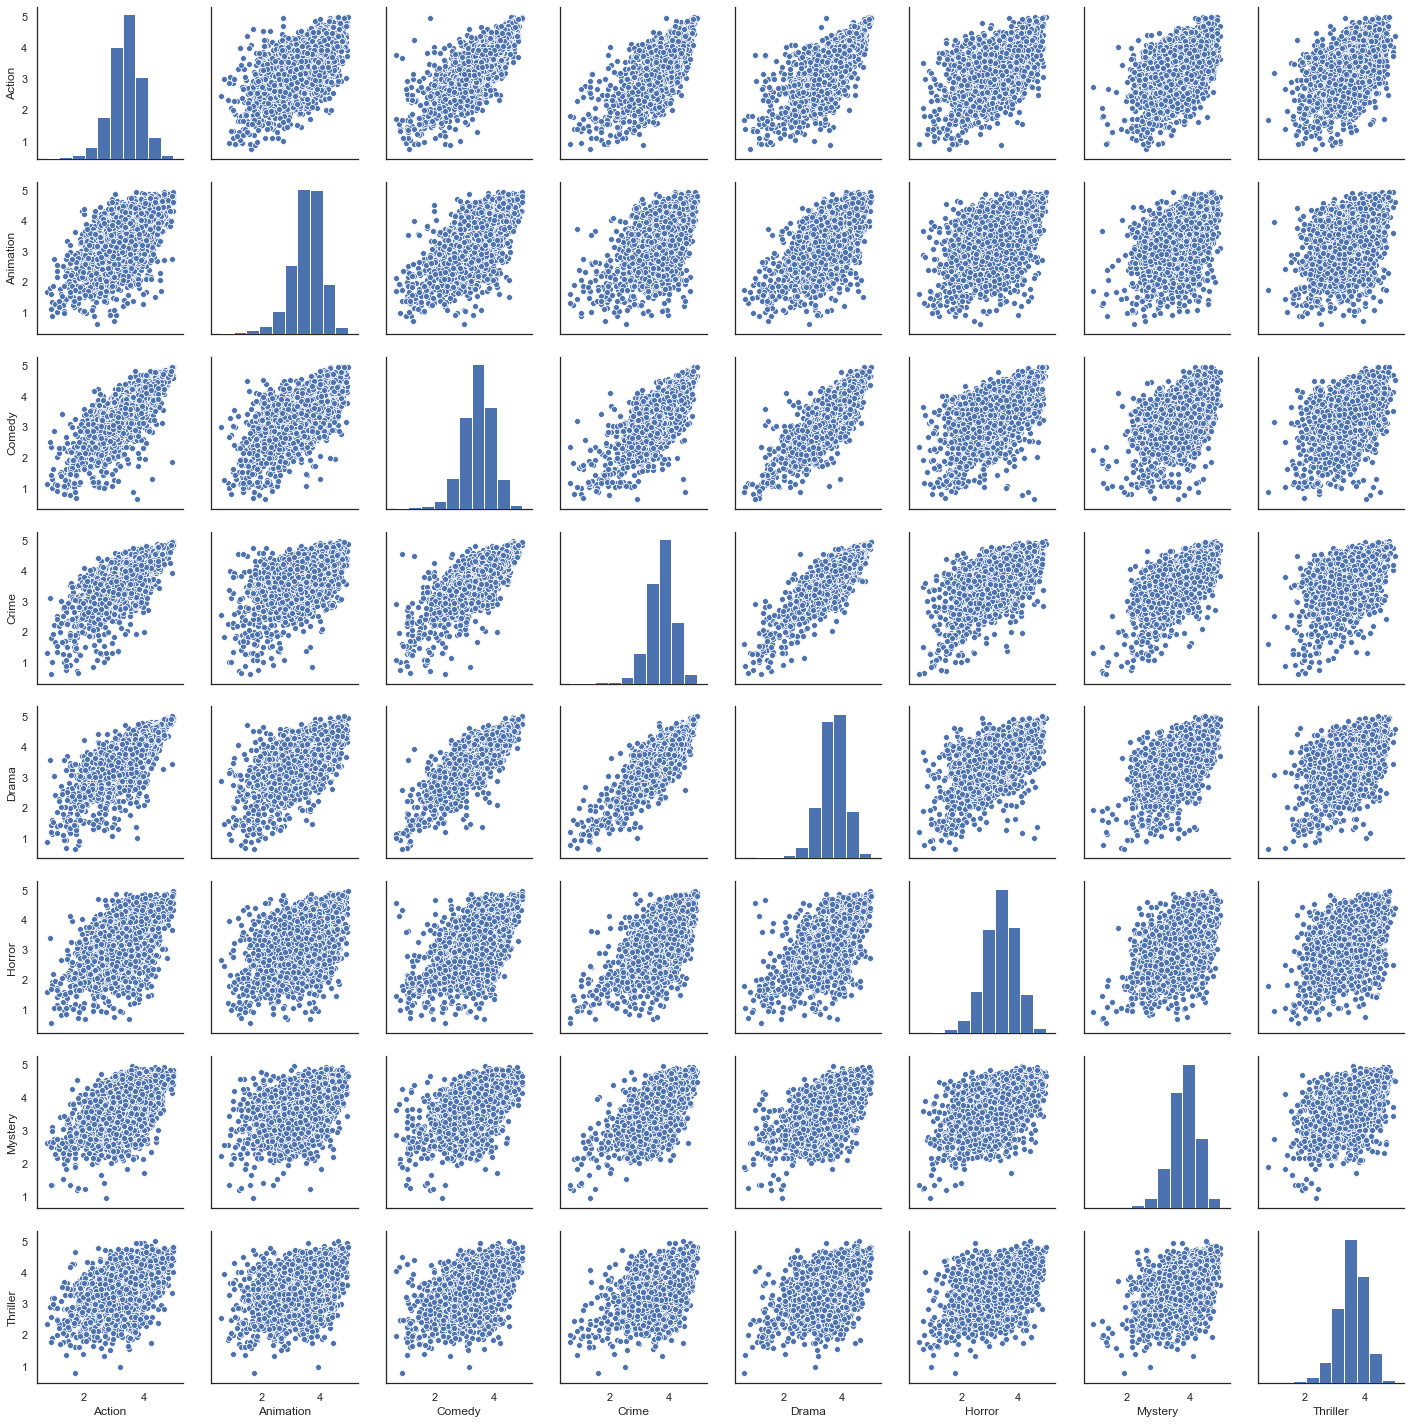

In [296]:
#sns.pairplot(genremat_nk_mean_f_adj)

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaled_genremat_nk_mean_f_adj = StandardScaler().fit_transform(genremat_nk_mean_f_adj.values)
scaled_genremat_nk_count_f = StandardScaler().fit_transform(genremat_nk_count_f.values)

(9782, 2)


Text(0.5, 1.0, 'UMAP projection of the Genres')

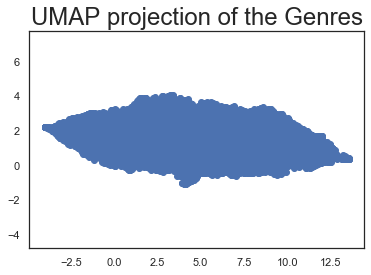

In [19]:
sns.set(style='white')

# Demention Reduction

# UMAP
# conda install -c conda-forge umap-learn

import umap
reducer = umap.UMAP()

embedding = reducer.fit_transform(scaled_genremat_nk_mean_f_adj)
#embedding = reducer.fit_transform(scaled_genremat_nk_count_f)
print(embedding.shape)

# plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genres', fontsize=24)

t-SNE done! Time elapsed: 96.67886281013489 seconds


Text(0.5, 1.0, 't-SNE projection of the Genres')

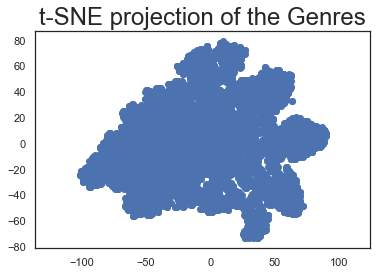

In [44]:
# from sklearn.manifold import TSNE
# import time

# time_start = time.time()
# #tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne = TSNE(n_components=2)
# embedding = tsne.fit_transform(scaled_genremat_nk_count_f)

# embedding.shape
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# # plot
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     #c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
#     )
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('t-SNE projection of the Genres', fontsize=24)

In [20]:
# k-mean clustering on UMAP embedding

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

X = embedding

In [300]:
# Distortion: It is calculated as the average of the squared distances from the cluster
#     centers of the respective clusters. Typically, the Euclidean distance metric is used.
# Inertia: It is the sum of squared distances of samples to their closest cluster center.

K = range(3,100)

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

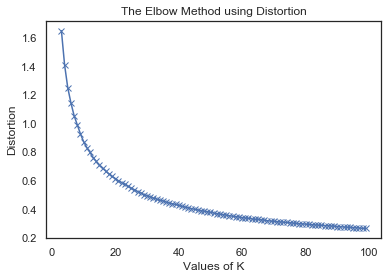

In [301]:
# Using the different values of Distortion
# for key,val in mapping1.items(): 
#     print(str(key)+' : '+str(val))
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

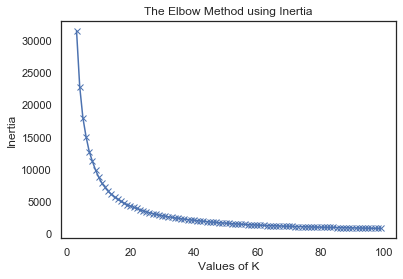

In [302]:
# Using the different values of Inertia
# for key,val in mapping2.items(): 
#     print(str(key)+' : '+str(val))
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Text(0.5, 1.0, 'UMAP projection of the Genres with K-Mean Labels')

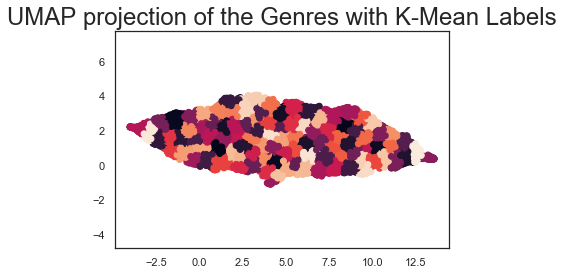

In [21]:
kmeans = KMeans(n_clusters=100)

# from sklearn.cluster import SpectralClustering
# kmeans = SpectralClustering(n_clusters=10)

kmeans.fit(X)
kmeans.cluster_centers_

# plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    c=kmeans.labels_
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genres with K-Mean Labels', fontsize=24)

In [22]:
# # count
# genremat_nk_count_f_w_label = genremat_nk_count_f.copy()
# genremat_nk_count_f_w_label['label'] = kmeans.labels_
# sns.pairplot(genremat_nk_count_f_w_label, hue='label')

# mean
# genremat_nk_mean_f_w_label = genremat_nk_mean_f.copy()
genremat_nk_mean_f_w_label = genremat_nk_mean_f_adj.copy()
genremat_nk_mean_f_w_label['label'] = kmeans.labels_
# sns.pairplot(genremat_nk_mean_f_w_label, hue='label')

In [23]:
# outlier!
print(genremat_nk_count_f.max())
print(genremat_nk_count_f.idxmax())

genre1
Action        3133
Animation      955
Comedy        6504
Crime         1816
Drama        10313
Horror        1400
Mystery        185
Thriller       375
dtype: int64
genre1
Action       72315
Animation    72315
Comedy       72315
Crime        72315
Drama        72315
Horror       72315
Mystery      72315
Thriller     72315
dtype: int64


//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


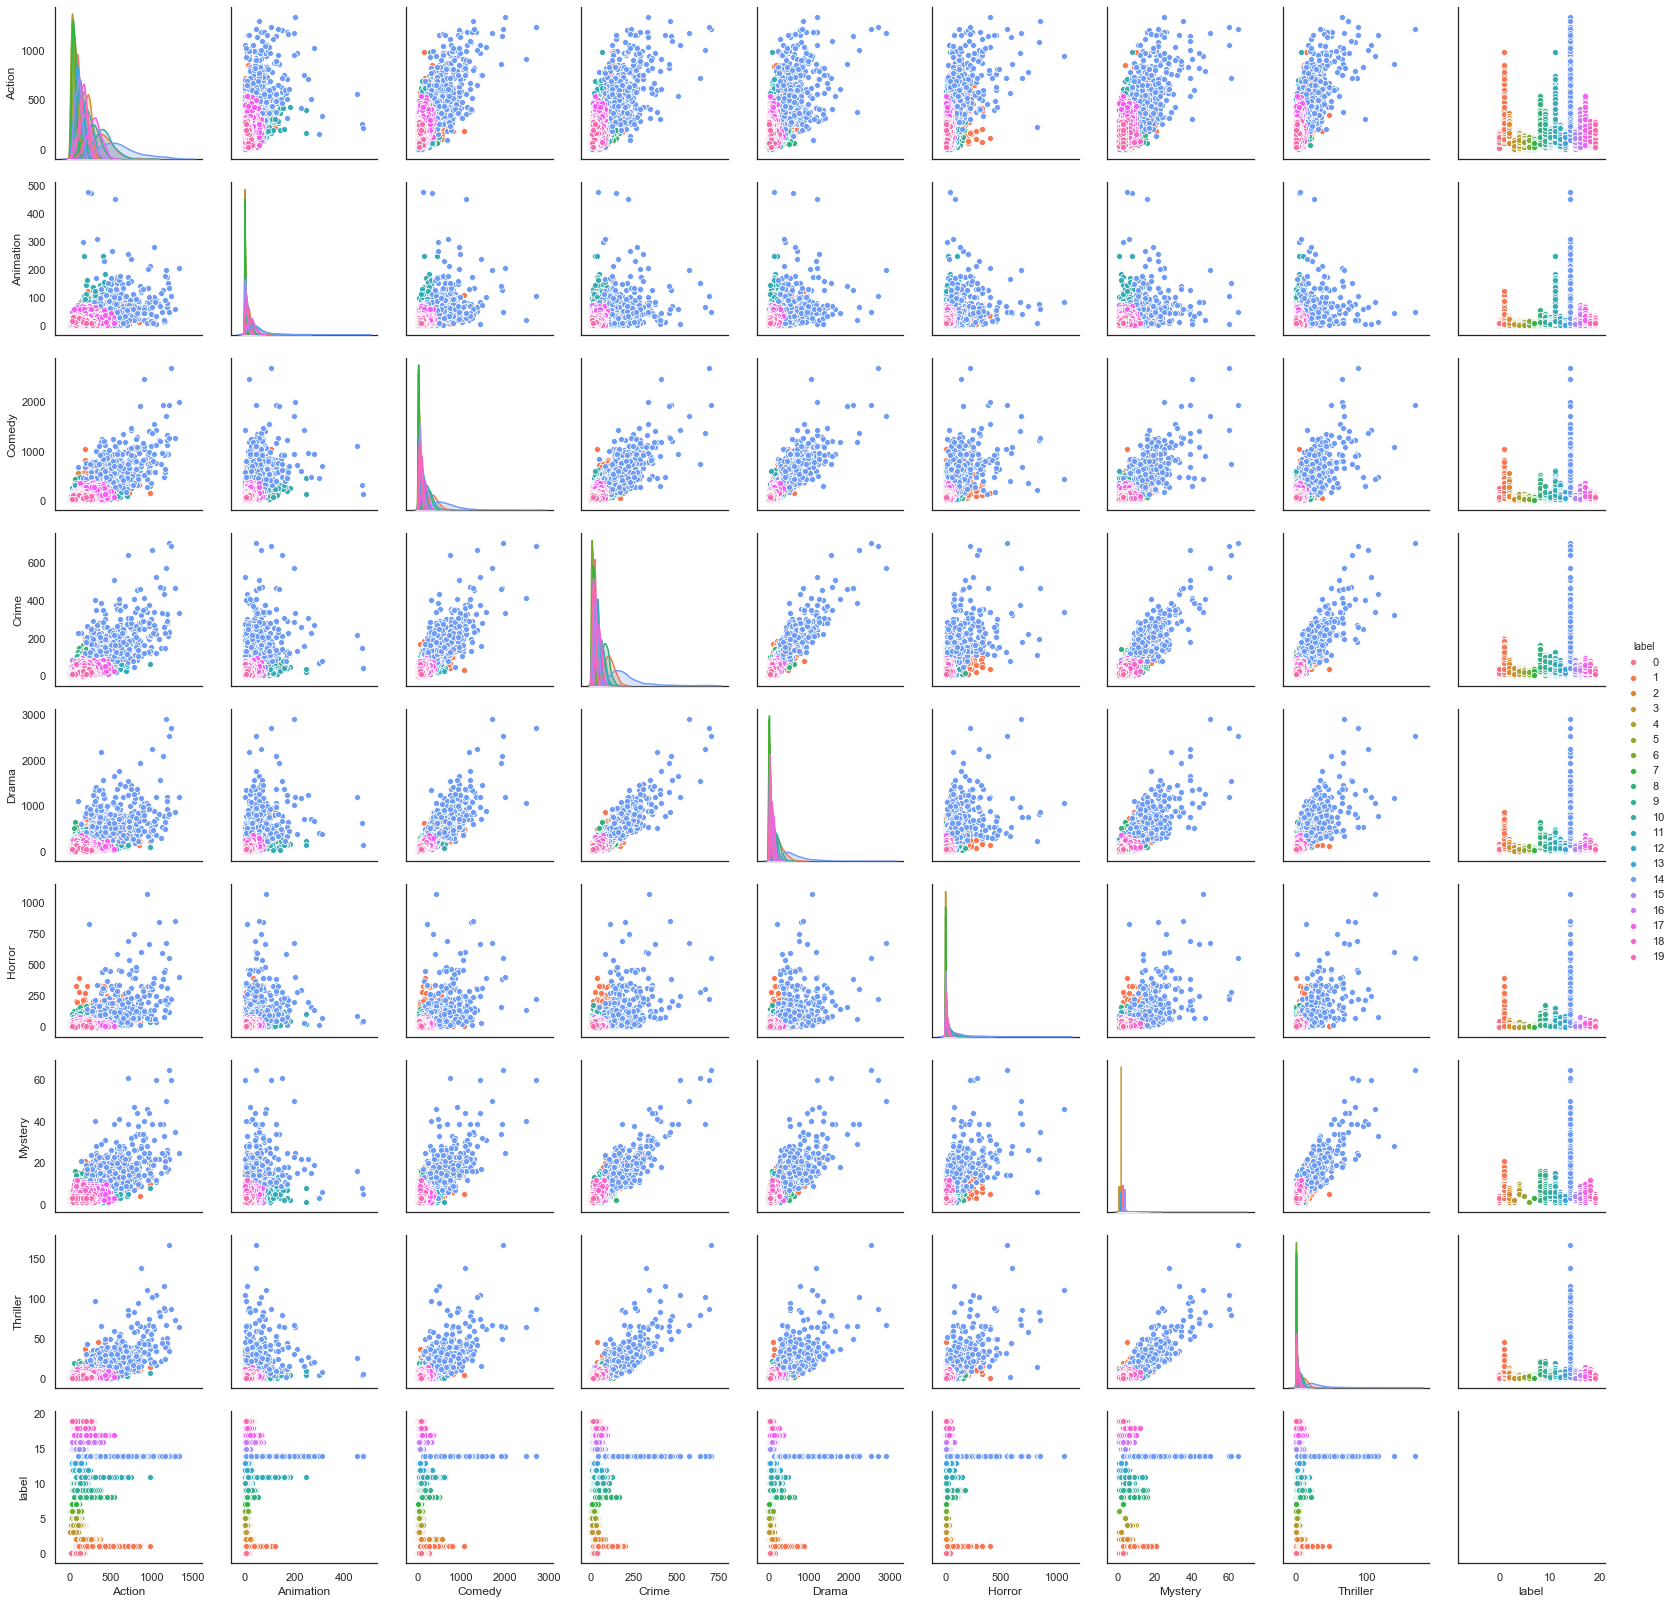

In [96]:
# count plot
# remove 72315

genremat_nk_count_f_w_label_wo_72315 = genremat_nk_count_f_w_label[genremat_nk_count_f_w_label.index != 72315]
sns.pairplot(genremat_nk_count_f_w_label_wo_72315, hue='label')

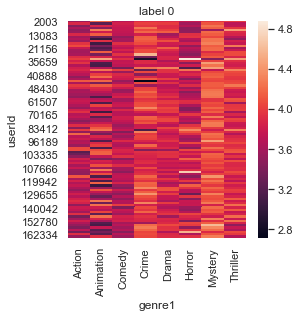

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(4,4))
sns.heatmap(genremat_nk_mean_f_w_label.loc[genremat_nk_mean_f_w_label['label']==0].drop(columns=['label']))

plt.title('label 0')
plt.show()
plt.savefig(os.path.abspath('figures/UMAP_100_label0.png'))

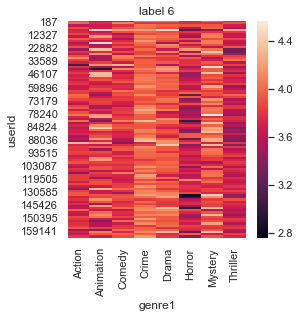

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(4,4))
sns.heatmap(genremat_nk_mean_f_w_label.loc[genremat_nk_mean_f_w_label['label']==6].drop(columns=['label']))

plt.title('label 6')
plt.show()
plt.savefig(os.path.abspath('figures/UMAP_100_label6.png'))

In [31]:
# save labels
genremat_nk_mean_f_w_label.to_csv(os.path.abspath('figures/UMAP_100.csv'))

In [32]:
####################################################
# Model
####################################################

# prepare for 'X'
k_ratings_f['year_n'] = k_ratings_f['year'].apply(lambda s:int(re.sub('[^0-9]', '', s)))
k_ratings_f['runtime_n'] = k_ratings_f['runtime'].apply(lambda s:int(re.sub('[^0-9]', '', s)))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [33]:
# # attach mean genre ratings
# k_ratings_f = pd.merge(k_ratings_f,genremat_nk_mean_f_adj,on='userId')

# attach label
k_ratings_f = pd.merge(k_ratings_f,genremat_nk_mean_f_w_label[['label']],on='userId')
k_ratings_f['label_c'] = k_ratings_f['label'].apply(lambda s:str(s))

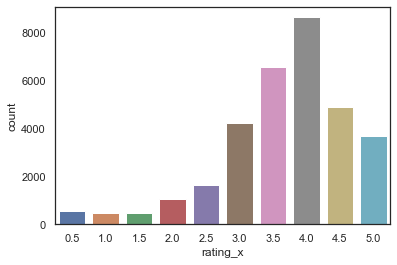

In [34]:
sns.countplot(k_ratings_f['rating_x'])

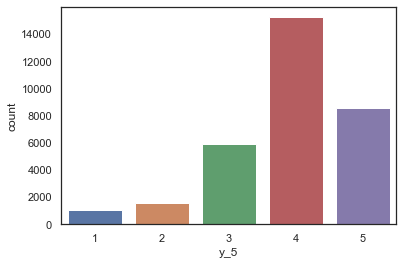

In [35]:
# prepare for 'y'

k_ratings_f['y_5'] = k_ratings_f['rating_x'].apply(lambda n:int(math.ceil(n)))
sns.countplot(x='y_5',data=k_ratings_f)

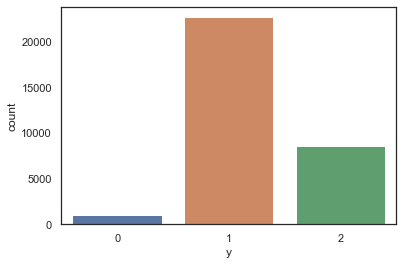

In [36]:
bins = [0,1,4,5]
y = [0,1,2]
k_ratings_f['y'] = pd.cut(k_ratings_f['rating_x'], bins, labels=y)

sns.countplot(x='y',data=k_ratings_f)

In [37]:
# director
k_ratings_f['director'] = k_ratings_f['director_actor'].apply(
    lambda s:re.sub('Director:|\n|-','',(s.split('Stars:')[0])).replace('|','').strip())
# re.sub('\n','',ratings_join['director_actor'][10000].split('Stars:')[1]).split(', ')
# re.sub(':|,',' ',re.sub('Director:|Stars|\n| ','',(ratings_join['director_actor'].iloc[5000])).replace('|','').strip())
director1 = []
director2 = []
for index, row in k_ratings_f.iterrows():
    director1.append(row['director'].split(', ')[0].replace('Directors:','').replace(' ',''))
    if row['director'].find('Directors:')>-1:
        director2.append(row['director'].split(', ')[1])
    else:
        director2.append('')

k_ratings_f['director1'] = pd.Series(director1)
k_ratings_f['director2'] = pd.Series(director2)

k_ratings_f.groupby('director1')['movieId'].count().sort_values(ascending=False)

director1
ChanwookPark             10642
BongJoonHo                6817
KidukKim                  3037
JeewoonKim                2282
HongjinNa                  906
SanghoYeon                 867
JeongbeomLee               576
JekyuKang                  522
ChangdongLee               452
JaeyoungKwak               324
SungsuKim                  205
HyungraeShim               204
SangsooHong                195
HoonjungPark               175
JoonHwanJang               173
MoonsaengKim               169
SeungwanRyoo               126
ByunggilJung               124
HanminKim                  121
HunJang                    120
JohnH.Lee                  113
TaegyunKim                 104
CheolsooJang               101
SangJinKim                  99
HaYoo                       94
SeonghunKim                 94
KwontaekIm                  92
ShinyeonWon                 84
PilsungYim                  84
KihyeongPark                76
                         ...  
JinyeongKim                  

In [38]:
# actor
actor1 = []
for index, row in k_ratings_f.iterrows():
    if row['director_actor'].find('Stars:')>-1:
        actor1.append(row['director_actor'].split('Stars:')[1].split(',')[0].replace('\n','').replace('-','').replace(' ',''))
    else:
        actor1.append('')

k_ratings_f['actor1'] = pd.Series(actor1)

k_ratings_f.groupby('actor1')['movieId'].count().sort_values(ascending=False)

actor1
MinsikChoi       6619
KanghoSong       4647
ChrisEvans       3119
YeongaeLee       1558
KidukKim         1385
ByunghunLee      1187
MinheeKim         901
SeungYunLee       870
YooGong           848
KapsuKim          686
YoonseokKim       567
TildaSwinton      559
WonBin            528
HyejaKim          468
DongGunJang       458
JungwooHa         362
SoojungLim        329
JunKunimura       307
TaeHyunCha        295
KyungguSol        276
WoosungJung       245
JaeyeongJeong     219
JasonBehr         204
JungSuh           195
AhInYoo           193
SukkyuHan         192
JungjaeLee        191
AndrewAbleson     169
HakyunShin        167
DoonaBae          136
                 ... 
EunjuLee            8
SeongJi             8
EunheeBang          8
MyunggonKim         8
TakumiBando         8
WooheeChun          8
JonghakBaek         8
JaerokKim           8
KimHyeYoon          8
YeojeongJo          7
ZiyiZhang           7
HyeonjuSon          7
EunchaeJung         7
JooWon              7
Yun

In [41]:
# tags
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

In [50]:
ml_tags_f = ml_tags[ml_tags.userId.isin(userId_list_f)]
ml_tags_f = ml_tags_f[ml_tags_f.movieId.isin(k_movie_list_f)]
ml_tags_merged = ml_tags_f.replace(np.nan, '').groupby(['userId','movieId'])['tag'].apply(' '.join).reset_index()

# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(ml_tags_merged['tag'])

tokenizer2 = Tokenizer(num_words=5000)
tokenizer2.fit_on_texts(ml_tags_merged['tag'])

X_tag = tokenizer2.texts_to_sequences(ml_tags_merged['tag'])
vocab_size2 = len(tokenizer2.word_index) + 1
maxlen2 = 25
X_tag = pad_sequences(X_tag, padding='post', maxlen=maxlen2)

# embedding_matrix2 = zeros((vocab_size2, 25))
# for word, index in tokenizer2.word_index.items():
#     embedding_vector2 = embeddings_dictionary.get(word)
#     if embedding_vector2 is not None:
#         embedding_matrix2[index] = embedding_vector2

X_tag = pd.DataFrame(X_tag,index=ml_tags_merged.index)
X_tag_f = pd.concat([ml_tags_merged, pd.DataFrame(X_tag)])
X_tag_f.drop('tag',axis=1,inplace=True)
X_tag_f.fillna(0,inplace=True)

In [52]:
k_ratings_f_w_tag = pd.merge(k_ratings_f,X_tag_f,how='left',
                             left_on=['movieId','userId'],right_on=['movieId','userId'])

In [55]:
k_ratings_f_w_tag.loc[0]

userId                                                                                                            181
movieId                                                                                                          8014
rating_x                                                                                                          1.5
timestamp                                                                                                  1547804302
name                                                                       Spring, Summer, Fall, Winter... and Spring
year                                                                                                           (2003)
rating_y                                                                                                            8
metascore                                                                                                          85
vote                                                    

In [62]:
# Feature Engineering
# 1. Remove 'certificate'
X = pd.concat([k_ratings_f_w_tag.drop(['userId','movieId','rating_x','timestamp','name','year',
                                  'rating_y','imdb_id','poster','genre',
                                  'certificate','runtime','director_actor','story','imdbId','tmdbId',
                                  'title','genres','genre1'
                                 , 'label','label_c'
                                 #,'metascore'
                                 ,'y_5'
                                 ,'y'
                                 #,'timestamp','vote'
                                 ,'director','director1','director2','actor1'
                                 ], axis = 1),
               pd.get_dummies(k_ratings_f_w_tag[[
                   #'certificate',
                   #'genre1',
                   'label_c','director1','actor1']], 
                              drop_first = True, dummy_na = True)],axis = 1)

# y = k_ratings_f_w_tag['y_5'].values
# y = k_ratings_f_w_tag['y'].copy()
y = k_ratings_f_w_tag['y'].cat.codes

# fill metascore null values with mean
X['metascore'].fillna(X['metascore'].mean(), inplace=True)
X.fillna(0,inplace=True)

In [58]:
# #############################################
# # Benchmark Estimate - Regression
# #############################################
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler

SEED = 42
TEST_SIZE = 0.2

def model_evaluation(y_test, predictions):
    print('Confusion Matrix\n\n{}'.format(confusion_matrix(y_test, predictions)))
    print('\n')
    print('Classification Report\n\n{}'.format(classification_report(y_test, predictions)))
    print('\n')
    print('Accuracy Score\n\n{}'.format(accuracy_score(y_test, predictions)))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, 
                                                    test_size = TEST_SIZE, random_state = SEED)

# data scale
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)

model_evaluation(y_test, predictions)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Confusion Matrix

[[  52  152    8]
 [  39 4139  360]
 [   6 1137  563]]


Classification Report

              precision    recall  f1-score   support

           0       0.54      0.25      0.34       212
           1       0.76      0.91      0.83      4538
           2       0.60      0.33      0.43      1706

    accuracy                           0.74      6456
   macro avg       0.63      0.50      0.53      6456
weighted avg       0.71      0.74      0.71      6456



Accuracy Score

0.7363692688971499


In [60]:
################
# ANN - test
################

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback

Y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X.values, Y, test_size = TEST_SIZE, random_state = SEED)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X.shape

(32278, 489)

In [62]:
model = Sequential()

model.add(Dense(978,activation='relu'))
model.add(Dense(1956,activation='relu'))
model.add(Dense(978,activation='relu'))
model.add(Dense(489,activation='relu'))
model.add(Dense(245,activation='relu'))

#model.add(Dense(3,activation='softmax'))
model.add(Dense(6,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
# model.add(Dense(1,activation='sigmoid'))
# model.compile(optimizer='adam',loss='binary_crossentropy')

callback = EarlyStopping(monitor='loss', patience=3)

model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=20
         ,callbacks=[callback])

Train on 25822 samples, validate on 6456 samples
Epoch 1/20
25822/25822 [==============================] - 8s 324us/sample - loss: 1.1587 - accuracy: 0.5113 - val_loss: 1.1024 - val_accuracy: 0.5262
Epoch 2/20
25822/25822 [==============================] - 8s 309us/sample - loss: 1.0843 - accuracy: 0.5374 - val_loss: 1.0967 - val_accuracy: 0.5390
Epoch 3/20
25822/25822 [==============================] - 8s 309us/sample - loss: 1.0550 - accuracy: 0.5515 - val_loss: 1.1151 - val_accuracy: 0.5316
Epoch 4/20
25822/25822 [==============================] - 8s 323us/sample - loss: 1.0288 - accuracy: 0.5611 - val_loss: 1.1282 - val_accuracy: 0.5279
Epoch 5/20
25822/25822 [==============================] - 8s 315us/sample - loss: 1.0024 - accuracy: 0.5736 - val_loss: 1.1259 - val_accuracy: 0.5300
Epoch 6/20
25822/25822 [==============================] - 8s 317us/sample - loss: 0.9753 - accuracy: 0.5820 - val_loss: 1.1594 - val_accuracy: 0.5254
Epoch 7/20
25822/25822 [===========================

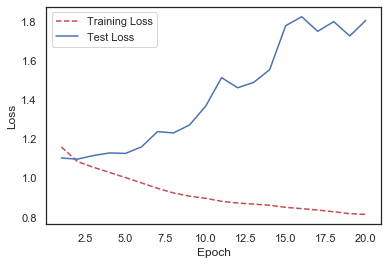

In [67]:
# Get training and test loss histories
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

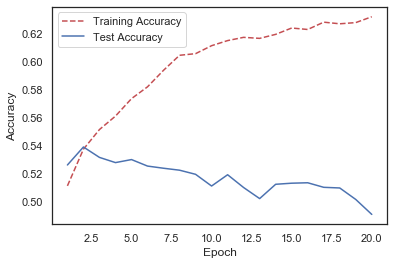

In [69]:
# Get training and test accuracy histories
training_accuracy = model.history.history['accuracy']
test_accuracy = model.history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [82]:
#####################
# NLP + ANN
#####################

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM,Input, Dropout, Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import sequence


# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
# from keras.layers import Flatten, LSTM
# from keras.layers import GlobalMaxPooling1D
# from keras.models import Model
# from keras.layers.embeddings import Embedding
# from keras.preprocessing.text import Tokenizer
# from keras.layers import Input
# from keras.layers.merge import Concatenate

callback = EarlyStopping(monitor='loss', patience=3)

In [65]:
k_ratings_f_w_tag.iloc[0]

userId                                                                                                            181
movieId                                                                                                          8014
rating_x                                                                                                          1.5
timestamp                                                                                                  1547804302
name                                                                       Spring, Summer, Fall, Winter... and Spring
year                                                                                                           (2003)
rating_y                                                                                                            8
metascore                                                                                                          85
vote                                                    

In [66]:
# Feature Engineering
# 1. Remove 'certificate'
X = pd.concat([k_ratings_f_w_tag.drop(['userId','movieId','rating_x','timestamp','name','year','rating_y',
                                 # 'metascore',
                                 'imdb_id','poster','genre',
                                 'certificate','runtime','director_actor', 
                                 # 'story', 
                                 'imdbId','tmdbId',
                                 'title','genres','genre1',
                                 'label','label_c',
                                 'y_5','y',
                                 # 'timestamp','vote',
                                 'director','director1','director2','actor1'
                                 ], axis = 1),
               pd.get_dummies(k_ratings_f_w_tag[[
                   #'certificate',
                   #'genre1',
                   'label_c','director1','actor1']], 
                              drop_first = True, dummy_na = True)],axis = 1)

# y = k_ratings_f_w_tag['y_5']
y = k_ratings_f_w_tag['y']

# y = k_ratings_f_w_tag['y'].cat.codes

# fill metascore null values with mean
X['metascore'].fillna(X['metascore'].mean(), inplace=True)
X.fillna(0,inplace=True)

In [67]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode target labels.
y = label_encoder.fit_transform(y)
# Y = to_categorical(y-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = SEED)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [68]:
#############################
# Model with Text Inputs Only
#############################

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)            
    # Removing "See full summary »"
    sentence = sentence.replace('See full summary', ' ')
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X1_train = []
sentences = list(X_train["story"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))
    
X1_test = []
sentences = list(X_test["story"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

In [69]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 50 # 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [108]:
# data scale
# scaler1 = MinMaxScaler()
scaler1 = StandardScaler()
X1_train = scaler1.fit_transform(X1_train)
X1_test = scaler1.transform(X1_test)

In [71]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file_link = p_data_src+'/glove.6B/glove.6B.50d.txt' # glove file link

with open(glove_file_link, 'r') as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [72]:
###############
# model 2
###############

X2_train = X_train.drop('story', axis=1).copy().values
X2_test = X_test.drop('story', axis=1).copy().values

In [109]:
# data scale
# scaler2 = MinMaxScaler()
scaler2 = StandardScaler()
X2_train = scaler2.fit_transform(X2_train)
X2_test = scaler2.transform(X2_test)

In [74]:
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(X.shape[1]-1,))

In [75]:
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

In [100]:
tf.keras.backend.clear_session()

# dense_layer_1 = Dense(978, activation='relu')(input_2)
# dense_layer_2 = Dense(1956, activation='relu')(dense_layer_1)
# dense_layer_3 = Dense(978, activation='relu')(dense_layer_2)
# dense_layer_4 = Dense(489, activation='relu')(dense_layer_3)
# dense_layer_5 = Dense(245, activation='relu')(dense_layer_4)

dense_layer_1 = Dense(1028, activation='relu')(input_2)
dense_layer_2 = Dense(2056, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(1028, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(514, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(257, activation='relu')(dense_layer_4)

# dense_layer_1 = Dense(343, activation='relu')(input_2)
# dense_layer_2 = Dense(257, activation='relu')(dense_layer_1)

In [101]:
# concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
# dense_layer_3 = Dense(10, activation='relu')(concat_layer)
# # output = Dense(5, activation='softmax')(dense_layer_6)
# output = Dense(3, activation='softmax')(dense_layer_3)
# model = Model(inputs=[input_1, input_2], outputs=output)

concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_5])
dense_layer_6 = Dense(10, activation='relu')(concat_layer)
# output = Dense(5, activation='softmax')(dense_layer_6)
output = Dense(3, activation='softmax')(dense_layer_6)
model = Model(inputs=[input_1, input_2], outputs=output)

# deep_inputs = Input(shape=(maxlen,))
# embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(deep_inputs)
# LSTM_Layer_1 = LSTM(128)(embedding_layer)
# dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
# model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# from keras.utils import plot_model
# plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1028)         529420      input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2056)         2115624     dense[0][0]                      
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 50)]         0                                            
______________________________________________________________________________________________

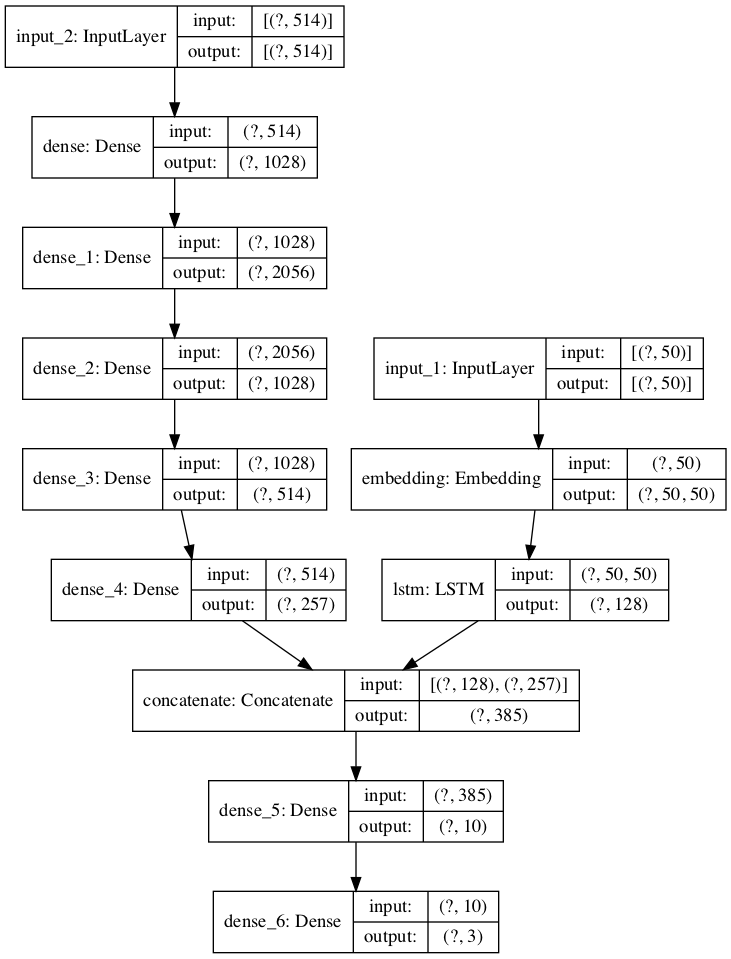

In [102]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='figures/model_plot3.png', show_shapes=True, show_layer_names=True)

In [103]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=10, 
#                     callbacks=[callback], verbose=1, validation_split=0.2)

# history = model.fit(x=[X1_train, X2_train], y=y_train, callbacks=[callback]
#                     ,batch_size=128, epochs=100, verbose=1, validation_split=0.2)

history = model.fit(x=[X1_train, X2_train], y=y_train, validation_data=([X1_test, X2_test],y_test),
                    callbacks=[callback],
                    batch_size=128, epochs=100, verbose=1)

Train on 25822 samples, validate on 6456 samples
Epoch 1/100
25822/25822 [==============================] - 30s 1ms/sample - loss: 0.6906 - accuracy: 0.6995 - val_loss: 0.6643 - val_accuracy: 0.7029
Epoch 2/100
25822/25822 [==============================] - 31s 1ms/sample - loss: 0.6464 - accuracy: 0.7016 - val_loss: 0.6510 - val_accuracy: 0.7029
Epoch 3/100
25822/25822 [==============================] - 30s 1ms/sample - loss: 0.6260 - accuracy: 0.7030 - val_loss: 0.6257 - val_accuracy: 0.7023
Epoch 4/100
25822/25822 [==============================] - 28s 1ms/sample - loss: 0.5961 - accuracy: 0.7233 - val_loss: 0.6114 - val_accuracy: 0.7282
Epoch 5/100
25822/25822 [==============================] - 28s 1ms/sample - loss: 0.5805 - accuracy: 0.7353 - val_loss: 0.6099 - val_accuracy: 0.7280
Epoch 6/100
25822/25822 [==============================] - 29s 1ms/sample - loss: 0.5697 - accuracy: 0.7391 - val_loss: 0.6059 - val_accuracy: 0.7325
Epoch 7/100
25822/25822 [==========================

Epoch 55/100
25822/25822 [==============================] - 28s 1ms/sample - loss: 0.3859 - accuracy: 0.8039 - val_loss: 1.3905 - val_accuracy: 0.6987
Epoch 56/100
25822/25822 [==============================] - 28s 1ms/sample - loss: 0.3825 - accuracy: 0.8044 - val_loss: 1.3793 - val_accuracy: 0.7090
Epoch 57/100
25822/25822 [==============================] - 28s 1ms/sample - loss: 0.3836 - accuracy: 0.8052 - val_loss: 1.3345 - val_accuracy: 0.7046
Epoch 58/100
25822/25822 [==============================] - 28s 1ms/sample - loss: 0.3800 - accuracy: 0.8050 - val_loss: 1.3702 - val_accuracy: 0.7012
Epoch 59/100
25822/25822 [==============================] - 32s 1ms/sample - loss: 0.3819 - accuracy: 0.8069 - val_loss: 1.3460 - val_accuracy: 0.7048
Epoch 60/100
25822/25822 [==============================] - 29s 1ms/sample - loss: 0.3858 - accuracy: 0.8063 - val_loss: 1.3295 - val_accuracy: 0.6964
Epoch 61/100
25822/25822 [==============================] - 30s 1ms/sample - loss: 0.3765 - ac

In [104]:
# cross_validation?

score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

6456/6456 [==============================] - 4s 558us/sample - loss: 1.5592 - accuracy: 0.6970
Test Score: 1.5592442140851026
Test Accuracy: 0.697026


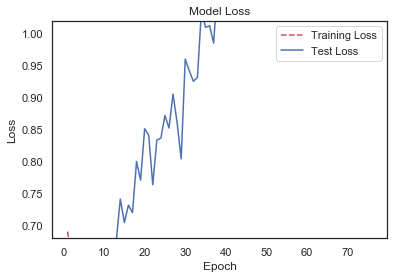

<Figure size 432x288 with 0 Axes>

In [105]:
# Get training and test loss histories
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.ylim(top=1.02)
plt.ylim(bottom=0.68)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()
plt.savefig(os.path.abspath('figures/Model_Loss.png'))

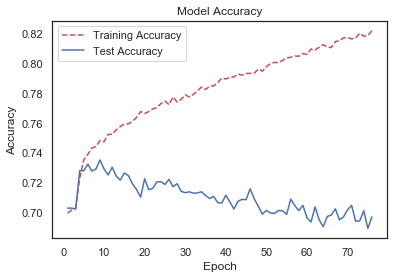

<Figure size 432x288 with 0 Axes>

In [107]:
# Get training and test accuracy histories
training_accuracy = model.history.history['accuracy']
test_accuracy = model.history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()
plt.savefig(os.path.abspath('figures/Model_Accuracy.png'))

In [ ]:
# train full dataset

In [110]:
# save model
model.save("final_model_traindata_v1.h5")

import joblib
joblib.dump(scaler1,'scaler1.pkl')
joblib.dump(scaler2,'scaler2.pkl')

['scaler2.pkl']

In [111]:
# load model
from tensorflow.keras.models import load_model
ratings_model = load_model('final_model_traindata_v1.h5')
ratings_scaler1 = joblib.load('scaler1.pkl')
ratings_scaler2 = joblib.load('scaler2.pkl')

In [194]:
# def return_prediction(model,scaler1,scaler2,sample_json):
#     classes = np.array([1,2,3])
#     class_ind = model.predict_classes()

In [150]:
reviewers_mat = k_ratings_f[['userId','label','label_c']].copy()
movies_mat = k_ratings_f.drop(['userId','rating_x','timestamp','label','label_c'], axis=1).copy()
# movies_mat = k_ratings_f.drop(['userId','rating_x','timestamp','label','label_c','story'], axis=1).copy()
# storys_mat = k_ratings_f[['movieId','story']].copy()

reviewers_mat = reviewers_mat.drop_duplicates(subset='userId')
movies_mat = movies_mat.drop_duplicates(subset='movieId')
# storys_mat = storys_mat.drop_duplicates(subset='movieId')

In [151]:
print('# reviewers: {}'.format(len(reviewers_mat)))
print('# movies: {}'.format(len(movies_mat)))

# reviewers: 9782
# movies: 353


In [160]:
reviewers_mat['joincol'] = 1
movies_mat['joincol'] = 1
megamat = pd.merge(reviewers_mat,movies_mat,how='outer',on='joincol')

In [163]:
megamat.head(100)

,userId,label,label_c,joincol,movieId,name,year,rating_y,metascore,vote,...,genres,genre1,year_n,runtime_n,y_5,y,director,director1,director2,actor1
0,181,34,34,1,8014,"Spring, Summer, Fall, Winter... and Spring",(2003),8.0,85.0,74747.0,...,Drama,Drama,2003,103,2,1,Kiduk Kim,KidukKim,,KidukKim
1,181,34,34,1,27773,Oldboy,(2003),8.4,77.0,494073.0,...,Mystery|Thriller,Mystery,2003,120,4,1,Chanwook Park,ChanwookPark,,MinsikChoi
2,181,34,34,1,107406,Snowpiercer,(2013),7.1,84.0,292313.0,...,Action|Drama|Sci-Fi,Action,2013,126,1,0,Bong Joon Ho,BongJoonHo,,ChrisEvans
3,181,34,34,1,158783,The Handmaiden,(2016),8.1,84.0,100030.0,...,Drama|Romance|Thriller,Drama,2016,145,2,1,Chanwook Park,ChanwookPark,,MinheeKim
4,181,34,34,1,27592,Sympathy for Mr. Vengeance,(2002),7.6,56.0,60133.0,...,Crime|Drama,Crime,2002,129,2,1,Chanwook Park,ChanwookPark,,KanghoSong
5,181,34,34,1,51709,The Host,(2006),7.1,85.0,100024.0,...,Comedy|Drama|Horror|Sci-Fi|Thriller,Comedy,2006,120,1,0,Bong Joon Ho,BongJoonHo,,KanghoSong
6,181,34,34,1,82667,I Saw the Devil,(2010),7.8,67.0,103826.0,...,Crime|Thriller,Crime,2010,144,1,0,Jeewoon Kim,JeewoonKim,,ByunghunLee
7,181,34,34,1,159061,The Wailing,(2016),7.5,81.0,44565.0,...,Mystery|Thriller,Mystery,2016,156,1,0,Hongjin Na,HongjinNa,,JunKunimura
8,181,34,34,1,202439,Parasite,(2019),8.6,96.0,421004.0,...,Comedy|Drama,Comedy,2019,132,2,1,Bong Joon Ho,BongJoonHo,,KanghoSong
9,181,34,34,1,30803,3-Iron,(2004),8.0,72.0,47924.0,...,Drama|Romance,Drama,2004,88,4,1,Kiduk Kim,KidukKim,,SeungYunLee


In [148]:
k_ratings_f

,userId,movieId,rating_x,timestamp,name,year,rating_y,metascore,vote,imdb_id,...,year_n,runtime_n,label,label_c,y_5,y,director,director1,director2,actor1
0,181,8014,1.5,1547804302,"Spring, Summer, Fall, Winter... and Spring",(2003),8.0,85.0,74747.0,tt0374546,...,2003,103,34,34,2,1,Kiduk Kim,KidukKim,,KidukKim
1,181,27773,3.5,1547803413,Oldboy,(2003),8.4,77.0,494073.0,tt0364569,...,2003,120,34,34,4,1,Chanwook Park,ChanwookPark,,MinsikChoi
2,181,107406,1.0,1547806302,Snowpiercer,(2013),7.1,84.0,292313.0,tt1706620,...,2013,126,34,34,1,0,Bong Joon Ho,BongJoonHo,,ChrisEvans
3,181,158783,2.0,1547804998,The Handmaiden,(2016),8.1,84.0,100030.0,tt4016934,...,2016,145,34,34,2,1,Chanwook Park,ChanwookPark,,MinheeKim
4,181,27592,2.0,1547804683,Sympathy for Mr. Vengeance,(2002),7.6,56.0,60133.0,tt0310775,...,2002,129,34,34,2,1,Chanwook Park,ChanwookPark,,KanghoSong
5,181,51709,1.0,1547804670,The Host,(2006),7.1,85.0,100024.0,tt0468492,...,2006,120,34,34,1,0,Bong Joon Ho,BongJoonHo,,KanghoSong
6,181,82667,0.5,1548873599,I Saw the Devil,(2010),7.8,67.0,103826.0,tt1588170,...,2010,144,34,34,1,0,Jeewoon Kim,JeewoonKim,,ByunghunLee
7,181,159061,0.5,1547806997,The Wailing,(2016),7.5,81.0,44565.0,tt5215952,...,2016,156,34,34,1,0,Hongjin Na,HongjinNa,,JunKunimura
8,181,202439,1.5,1568045913,Parasite,(2019),8.6,96.0,421004.0,tt6751668,...,2019,132,34,34,2,1,Bong Joon Ho,BongJoonHo,,KanghoSong
9,541,8014,4.5,1542827252,"Spring, Summer, Fall, Winter... and Spring",(2003),8.0,85.0,74747.0,tt0374546,...,2003,103,98,98,5,2,Kiduk Kim,KidukKim,,KidukKim


In [174]:
# save data
k_ratings_f.to_csv(os.path.abspath('../data/k_ratings_f.csv'),index=False)
k_ratings_f_w_tag.to_csv(os.path.abspath('../data/k_ratings_f_w_tag.csv'),index=False)

In [188]:
type(k_ratings_f['label_c'].iloc[0])

str